In [31]:
#added simple calculated feature and
#compare to a base model
import pandas as pd
import numpy as np

In [32]:
#data
dataset = pd.read_csv('/home/kate/data/ClaimPrediction/fdata_v1_encd.csv', index_col=None)
target_column = 'hasclaim'

In [33]:
#models and analyzing results directory
ModelsDir='/home/kate/data/ClaimPrediction/s8_SimpleCalculationShortModel/'

In [34]:
#comparing model metrics with t-test
#and save results
import scipy.stats as stats
def AnalyzeAndSaveModelsResults(result_df,result_lst,ModelName,filename):
    df=pd.DataFrame([result_lst])
    TestSizeColumns=['S0.45','S0.4','S0.35','S0.3','S0.25','S0.2','S0.15','S0.1']
    #TestSizeColumns=['S0.2','S0.15','S0.1']
    df.columns=['Model']+TestSizeColumns
    #mean
    df['Mean'] = df.drop('Model', axis=1).mean(axis=1)
    df['t-pvalue'] = 1
    df['t-statistic'] = 0
    df['Group'] = 1
    #t-test with base model
    if ModelName!='BaseModel':
        base_model=result_df[result_df['Model'] == 'BaseModel'].iloc[0]
        current_model=df.iloc[0]
        t=stats.ttest_ind(base_model[TestSizeColumns].tolist(),current_model[TestSizeColumns].tolist())
        line_to_save=[current_model['Model']]
        line_to_save.extend(current_model[TestSizeColumns].tolist())
        line_to_save.append(current_model[TestSizeColumns].mean())
        line_to_save.append(t.pvalue)
        line_to_save.append(t.statistic)
        if ((t.pvalue<=0.05) and (base_model['Mean']<current_model['Mean'])):
            line_to_save.append(2)
        elif ((t.pvalue<=0.05) and (base_model['Mean']>current_model['Mean'])):
            line_to_save.append(3)    
        else:
            line_to_save.append(1)                  
        df_to_save=pd.DataFrame([line_to_save])
        df_to_save.columns=['Model']+TestSizeColumns+['Mean','t-pvalue','t-statistic','Group']
        result_df=result_df.append(df_to_save, ignore_index=True)
    else:
        result_df=result_df.append(df, ignore_index=True)
    result_df.to_csv(ModelsDir+filename, index = False)
    return result_df

In [35]:
#xgb library and parameters to tune later
import xgboost as xgb
xgb_params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True}

In [36]:
#Evaluation metric to be used in tuning
from sklearn.metrics import roc_auc_score
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [37]:
#Random Undersampler to balance the dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
#ratio=0.918 to tune later

In [38]:
#StratifiedKFold
from sklearn.model_selection import StratifiedKFold
nrounds=5000 # need to change to 2000
kfold = 10  # need to change to 10
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [39]:
#splitting to train/test in the loop below
from sklearn.model_selection import train_test_split

In [40]:
#each line in the file contains the model name and set of features to analize
models = pd.read_csv(ModelsDir+'Models.csv', index_col=None)

In [41]:
#summary for test and train metrics for each model to test overfitting
models_test_gini_df=pd.DataFrame()
models_test_roc_auc_df=pd.DataFrame()
#
models_train_gini_df=pd.DataFrame()
models_train_roc_auc_df=pd.DataFrame()

In [42]:
for index, row in models.iterrows():
    #for test and train metrics for each model to test overfitting
    gini_test_lst=[]
    roc_auc_test_lst=[]
    gini_train_lst=[]
    roc_auc_train_lst=[]
    #Starting analyzing metric
    print (index, ': Analyzing model %s'%row['Model'])
    gini_test_lst.append(row['Model'])
    roc_auc_test_lst.append(row['Model'])
    gini_train_lst.append(row['Model'])
    roc_auc_train_lst.append(row['Model'])
    featureset=row[2:51].tolist()
    featureset=[x for x in featureset if str(x) != 'nan']
    #get calculation from Formula column
    Formula=row['Formula']
    #calculate if not empty and add into the feature set
    if str(Formula) != 'nan':
        dataset[row['Model']]=dataset.eval(Formula)
        featureset.append(row['Model'])
    #calculating metrics for the current featureset and 
    #several data sizes
    for s in (0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1):
    #for s in (0.2,0.15,0.1):
        print ('Test size %s'%s)
        X, X_test, y, y_test = train_test_split(dataset.loc[:,featureset], dataset[target_column], test_size=s, random_state=42)
        #prediction dataframes
        y_pred_test=pd.DataFrame(index=y_test.index)
        y_pred_test[target_column]=0
        y_pred_train=pd.DataFrame(index=y.index)
        y_pred_train[target_column]=0
        #
        X = X.values
        y = y.values
        #Stratified Fold
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(' xgb kfold: {}  of  {} : '.format(i+1, kfold))
            #getting fold data
            X_train, X_valid = X[train_index], X[test_index]
            y_train, y_valid = y[train_index], y[test_index]
            #balancing dataset
            X_res, y_res = rus.fit_sample(X_train, y_train)
            #applying XGB
            d_train = xgb.DMatrix(X_res, y_res) 
            d_valid = xgb.DMatrix(X_valid, y_valid) 
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            xgb_model = xgb.train(xgb_params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                          feval=gini_xgb, maximize=True, verbose_eval=1000)
            y_pred_test[target_column] +=  xgb_model.predict(xgb.DMatrix(X_test.values), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
            y_pred_train[target_column] += xgb_model.predict(xgb.DMatrix(X), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
        #Prediction results
        #test
        g=gini(y_test,y_pred_test)/gini(y_test,y_test)
        print('Test Gini - %f'%g)
        gini_test_lst.append(g)
        ROC_AUC=roc_auc_score(y_test, y_pred_test)
        print('Test ROC_AUC - %f'%ROC_AUC)
        roc_auc_test_lst.append(ROC_AUC)
        #train
        g=gini(y,y_pred_train)/gini(y,y)
        print('Train Gini - %f'%g)
        gini_train_lst.append(g)
        ROC_AUC=roc_auc_score(y, y_pred_train)
        print('Train ROC_AUC - %f'%ROC_AUC)
        roc_auc_train_lst.append(ROC_AUC)
    #save model analysis results
    models_test_gini_df=AnalyzeAndSaveModelsResults(models_test_gini_df,gini_test_lst,row['Model'],'models_test_gini.csv')
    models_test_roc_auc_df=AnalyzeAndSaveModelsResults(models_test_roc_auc_df,roc_auc_test_lst,row['Model'],'models_test_roc_auc.csv')
    models_train_gini_df=AnalyzeAndSaveModelsResults(models_train_gini_df,gini_train_lst,row['Model'],'models_train_gini.csv')
    models_train_roc_auc_df=AnalyzeAndSaveModelsResults(models_train_roc_auc_df,roc_auc_train_lst,row['Model'],'models_train_roc_auc.csv')

0 : Analyzing model BaseModel
Test size 0.45
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.663563	valid-auc:0.625963	train-gini:0.220665	valid-gini:0.252015
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[347]	train-auc:0.793659	valid-auc:0.711208	train-gini:0.587316	valid-gini:0.422414

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.650528	valid-auc:0.642676	train-gini:0.195342	valid-gini:0.278029
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[458]	train-auc:0.809118	valid-auc:0.708581	train-gini:0.618235	valid-gini:0.417162

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.658017	valid-auc:0.607468	train-gini:0.203317	valid-gini:0.205278
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn'

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.654982	valid-auc:0.640297	train-gini:0.198048	valid-gini:0.261915
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[256]	train-auc:0.766538	valid-auc:0.710946	train-gini:0.533074	valid-gini:0.421893

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.646879	valid-auc:0.634389	train-gini:0.167517	valid-gini:0.245968
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[529]	train-auc:0.80629	valid-auc:0.708	train-gini:0.61258	valid-gini:0.416

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.648395	valid-auc:0.619217	train-gini:0.193452	valid-gini:0.226469
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.645783	valid-auc:0.628905	train-gini:0.125922	valid-gini:0.251315
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[374]	train-auc:0.777265	valid-auc:0.708001	train-gini:0.554529	valid-gini:0.416001

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.638715	valid-auc:0.627772	train-gini:0.017484	valid-gini:0.262939
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[473]	train-auc:0.790601	valid-auc:0.717913	train-gini:0.581202	valid-gini:0.435825

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.645936	valid-auc:0.627432	train-gini:0.16751	valid-gini:0.262419
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best itera

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.646154	valid-auc:0.645879	train-gini:0.172396	valid-gini:0.290929
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[452]	train-auc:0.788292	valid-auc:0.711685	train-gini:0.576582	valid-gini:0.423369

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.644953	valid-auc:0.627779	train-gini:0.175245	valid-gini:0.263092
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[760]	train-auc:0.815302	valid-auc:0.713893	train-gini:0.630602	valid-gini:0.427787

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.645535	valid-auc:0.609651	train-gini:0.157612	valid-gini:0.229962
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iter

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.639206	valid-auc:0.63907	train-gini:0.142349	valid-gini:0.302895
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[409]	train-auc:0.76985	valid-auc:0.705973	train-gini:0.539698	valid-gini:0.411946

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.651141	valid-auc:0.625139	train-gini:0.174837	valid-gini:0.260903
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[335]	train-auc:0.764573	valid-auc:0.688741	train-gini:0.529142	valid-gini:0.377483

Test Gini - 0.396587
Test ROC_AUC - 0.698293
Train Gini - 0.466829
Train ROC_AUC - 0.733415
Test size 0.4
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.6478	valid-auc:0.63409	train-gini:0.168558	valid-gini:0.252514
Multiple eval metrics have been passed: 'valid-gini' will be us

Test Gini - 0.402999
Test ROC_AUC - 0.701499
Train Gini - 0.470358
Train ROC_AUC - 0.735179
Test size 0.3
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.651196	valid-auc:0.626429	train-gini:0.187613	valid-gini:0.258303
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[520]	train-auc:0.77185	valid-auc:0.706715	train-gini:0.543699	valid-gini:0.41343

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.650972	valid-auc:0.613171	train-gini:0.193837	valid-gini:0.222095
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[369]	train-auc:0.761882	valid-auc:0.69052	train-gini:0.523762	valid-gini:0.381043

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.642752	valid-auc:0.628141	train-gini:0.172638	valid-gini:0.241825
Multiple eval metrics have been passed: 'valid-gini' will be u

Stopping. Best iteration:
[486]	train-auc:0.753124	valid-auc:0.702264	train-gini:0.506245	valid-gini:0.40453

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.654046	valid-auc:0.644564	train-gini:0.213633	valid-gini:0.299623
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[602]	train-auc:0.76161	valid-auc:0.699157	train-gini:0.523218	valid-gini:0.398315

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.65668	valid-auc:0.641741	train-gini:0.219231	valid-gini:0.284841
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[381]	train-auc:0.74508	valid-auc:0.694356	train-gini:0.490153	valid-gini:0.38871

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.638542	valid-auc:0.640929	train-gini:0.159369	valid-gini:0.275715
Multiple eval metrics have been passed: 'valid-gini' will b

Stopping. Best iteration:
[633]	train-auc:0.76192	valid-auc:0.695553	train-gini:0.523838	valid-gini:0.391106

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.628334	valid-auc:0.639351	train-gini:0.119302	valid-gini:0.268956
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[579]	train-auc:0.756594	valid-auc:0.701689	train-gini:0.513187	valid-gini:0.403377

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.638982	valid-auc:0.631455	train-gini:0.164506	valid-gini:0.250889
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[605]	train-auc:0.758199	valid-auc:0.705078	train-gini:0.516396	valid-gini:0.410155

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.636358	valid-auc:0.647546	train-gini:0.16342	valid-gini:0.292211
Multiple eval metrics have been passed: 'valid-gini' wil

Stopping. Best iteration:
[501]	train-auc:0.776521	valid-auc:0.69223	train-gini:0.553039	valid-gini:0.38446

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.643967	valid-auc:0.6235	train-gini:0.148713	valid-gini:0.252161
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[478]	train-auc:0.772351	valid-auc:0.689624	train-gini:0.5447	valid-gini:0.379248

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.651421	valid-auc:0.612375	train-gini:0.182661	valid-gini:0.23494
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[291]	train-auc:0.754255	valid-auc:0.685454	train-gini:0.508504	valid-gini:0.37091

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.650673	valid-auc:0.628672	train-gini:0.170076	valid-gini:0.275922
Multiple eval metrics have been passed: 'valid-gini' will be u

Stopping. Best iteration:
[340]	train-auc:0.752565	valid-auc:0.696315	train-gini:0.505127	valid-gini:0.392629

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.646725	valid-auc:0.603284	train-gini:0.158375	valid-gini:0.21882
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[359]	train-auc:0.754962	valid-auc:0.681001	train-gini:0.509921	valid-gini:0.362001

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.642698	valid-auc:0.631569	train-gini:0.143744	valid-gini:0.273298
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[420]	train-auc:0.759103	valid-auc:0.692066	train-gini:0.518204	valid-gini:0.384133

Test Gini - 0.403197
Test ROC_AUC - 0.701599
Train Gini - 0.457083
Train ROC_AUC - 0.728541
Test size 0.25
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.641034	valid-

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[358]	train-auc:0.743381	valid-auc:0.697173	train-gini:0.486758	valid-gini:0.394345

Test Gini - 0.414817
Test ROC_AUC - 0.707409
Train Gini - 0.460982
Train ROC_AUC - 0.730491
Test size 0.15
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.64159	valid-auc:0.639213	train-gini:0.173195	valid-gini:0.267525
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[324]	train-auc:0.736881	valid-auc:0.701986	train-gini:0.473758	valid-gini:0.403972

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.645132	valid-auc:0.636493	train-gini:0.184926	valid-gini:0.27417
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[287]	train-auc:0.73564	valid-auc:0.696152	train-gini:0.471273	valid-gini:0.392306

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[674]	train-auc:0.793749	valid-auc:0.708686	train-gini:0.587496	valid-gini:0.417372

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.656555	valid-auc:0.624855	train-gini:0.208438	valid-gini:0.241582
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[336]	train-auc:0.762141	valid-auc:0.699979	train-gini:0.52428	valid-gini:0.399957

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.656573	valid-auc:0.648561	train-gini:0.218167	valid-gini:0.295767
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[342]	train-auc:0.765509	valid-auc:0.7035	train-gini:0.531015	valid-gini:0.407

 xgb kfold: 5  of  10

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[383]	train-auc:0.756104	valid-auc:0.708486	train-gini:0.512203	valid-gini:0.416971

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.648711	valid-auc:0.630269	train-gini:0.20778	valid-gini:0.249301
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[275]	train-auc:0.747842	valid-auc:0.70127	train-gini:0.495673	valid-gini:0.402538

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.651781	valid-auc:0.626895	train-gini:0.203811	valid-gini:0.248177
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[491]	train-auc:0.766003	valid-auc:0.69923	train-gini:0.532005	valid-gini:0.398459

 xgb kfold: 7  of 

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[422]	train-auc:0.754479	valid-auc:0.702588	train-gini:0.508954	valid-gini:0.405176

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.647142	valid-auc:0.637117	train-gini:0.199749	valid-gini:0.278788
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[469]	train-auc:0.758469	valid-auc:0.695283	train-gini:0.516937	valid-gini:0.390566

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.655818	valid-auc:0.629103	train-gini:0.21564	valid-gini:0.264567
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[783]	train-auc:0.78212	valid-auc:0.697676	train-gini:0.564238	valid-gini:0.395351

 xgb kfold: 9  of

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[369]	train-auc:0.752751	valid-auc:0.702829	train-gini:0.505497	valid-gini:0.405659

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.645741	valid-auc:0.617956	train-gini:0.183313	valid-gini:0.244222
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[310]	train-auc:0.745885	valid-auc:0.684716	train-gini:0.491762	valid-gini:0.369433

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.642688	valid-auc:0.631237	train-gini:0.161534	valid-gini:0.272423
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[435]	train-auc:0.754747	valid-auc:0.694747	train-gini:0.509491	valid-gini:0.389494

Test Gini - 0.

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[360]	train-auc:0.76936	valid-auc:0.688499	train-gini:0.538718	valid-gini:0.376996

Test Gini - 0.397467
Test ROC_AUC - 0.698733
Train Gini - 0.476701
Train ROC_AUC - 0.738351
Test size 0.4
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.6478	valid-auc:0.63409	train-gini:0.168558	valid-gini:0.252514
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[273]	train-auc:0.747834	valid-auc:0.682396	train-gini:0.495662	valid-gini:0.364792

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.649123	valid-auc:0.652994	train-gini:0.208136	valid-gini:0.295955
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.650972	valid-auc:0.613171	train-gini:0.193837	valid-gini:0.222095
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[339]	train-auc:0.759446	valid-auc:0.688848	train-gini:0.518889	valid-gini:0.377697

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.642752	valid-auc:0.628141	train-gini:0.172638	valid-gini:0.241825
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[617]	train-auc:0.7814	valid-auc:0.702608	train-gini:0.562799	valid-gini:0.405214

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.640499	valid-auc:0.644112	train-gini:0.165793	valid-gini:0.272086
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterat

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.65668	valid-auc:0.641741	train-gini:0.219231	valid-gini:0.284841
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[485]	train-auc:0.753823	valid-auc:0.69293	train-gini:0.507643	valid-gini:0.385859

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.638542	valid-auc:0.640929	train-gini:0.159369	valid-gini:0.275715
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[819]	train-auc:0.778273	valid-auc:0.707803	train-gini:0.556545	valid-gini:0.415606

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.641943	valid-auc:0.644034	train-gini:0.143197	valid-gini:0.285913
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterat

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.63852	valid-auc:0.638813	train-gini:0.152482	valid-gini:0.265869
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[602]	train-auc:0.760453	valid-auc:0.704195	train-gini:0.520905	valid-gini:0.40839

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.63677	valid-auc:0.652869	train-gini:0.155775	valid-gini:0.302242
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[359]	train-auc:0.741465	valid-auc:0.701227	train-gini:0.482926	valid-gini:0.402453

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.636199	valid-auc:0.621959	train-gini:0.126057	valid-gini:0.248474
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterati

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.649062	valid-auc:0.609131	train-gini:0.178614	valid-gini:0.228305
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[317]	train-auc:0.757486	valid-auc:0.682497	train-gini:0.514969	valid-gini:0.364996

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.648802	valid-auc:0.623186	train-gini:0.168345	valid-gini:0.264652
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[616]	train-auc:0.786169	valid-auc:0.704071	train-gini:0.572335	valid-gini:0.408142

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.638351	valid-auc:0.616802	train-gini:0.139376	valid-gini:0.243377
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best ite

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.642698	valid-auc:0.631569	train-gini:0.143744	valid-gini:0.273298
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[352]	train-auc:0.754439	valid-auc:0.68885	train-gini:0.508876	valid-gini:0.377699

Test Gini - 0.402833
Test ROC_AUC - 0.701417
Train Gini - 0.458881
Train ROC_AUC - 0.729441
Test size 0.25
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.640723	valid-auc:0.635698	train-gini:0.166523	valid-gini:0.284247
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[327]	train-auc:0.743815	valid-auc:0.696831	train-gini:0.487625	valid-gini:0.393665

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.646496	valid-auc:0.619374	train-gini:0.18821	valid-gini:0.262328
Multiple eval metrics have been passed: 'valid-gini' will b

Stopping. Best iteration:
[392]	train-auc:0.740632	valid-auc:0.702295	train-gini:0.481261	valid-gini:0.404588

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.645132	valid-auc:0.636493	train-gini:0.184926	valid-gini:0.27417
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[305]	train-auc:0.736379	valid-auc:0.69577	train-gini:0.472753	valid-gini:0.391542

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.648679	valid-auc:0.612662	train-gini:0.181381	valid-gini:0.236721
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[483]	train-auc:0.750532	valid-auc:0.704417	train-gini:0.501063	valid-gini:0.408834

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.645608	valid-auc:0.643885	train-gini:0.195488	valid-gini:0.284502
Multiple eval metrics have been passed: 'valid-gini' wil

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[325]	train-auc:0.76258	valid-auc:0.697448	train-gini:0.525156	valid-gini:0.394896

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.656573	valid-auc:0.648561	train-gini:0.218167	valid-gini:0.295767
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[342]	train-auc:0.766845	valid-auc:0.702369	train-gini:0.533687	valid-gini:0.40474

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.657452	valid-auc:0.60603	train-gini:0.213118	valid-gini:0.210442
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[286]	train-auc:0.760994	valid-auc:0.688408	train-gini:0.521986	valid-gini:0.376817

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.653165	valid-auc:0.618151	train-gini:0.195728	valid-gini:0.24748

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[405]	train-auc:0.761179	valid-auc:0.699307	train-gini:0.522355	valid-gini:0.398613

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.651343	valid-auc:0.628419	train-gini:0.207579	valid-gini:0.252277
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[409]	train-auc:0.759134	valid-auc:0.697613	train-gini:0.518266	valid-gini:0.395224

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.649109	valid-auc:0.63885	train-gini:0.204029	valid-gini:0.280865
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[363]	train-auc:0.756701	valid-auc:0.700957	train-gini:0.513399	valid-gini:0.401914

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.651767	valid-auc:0.609623	train-gini:0.201341	valid-gini:0.223

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[454]	train-auc:0.757709	valid-auc:0.696794	train-gini:0.515415	valid-gini:0.39359

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.655611	valid-auc:0.630279	train-gini:0.217238	valid-gini:0.266823
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[476]	train-auc:0.761426	valid-auc:0.697064	train-gini:0.52285	valid-gini:0.394128

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.656999	valid-auc:0.608248	train-gini:0.202289	valid-gini:0.229996
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[501]	train-auc:0.763961	valid-auc:0.680795	train-gini:0.527919	valid-gini:0.36159

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.65847	valid-auc:0.621037	train-gini:0.196384	valid-gini:0.25519

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[472]	train-auc:0.759082	valid-auc:0.685514	train-gini:0.518161	valid-gini:0.371027

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.642688	valid-auc:0.631237	train-gini:0.161534	valid-gini:0.272423
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[442]	train-auc:0.756149	valid-auc:0.694836	train-gini:0.512295	valid-gini:0.389672

Test Gini - 0.412027
Test ROC_AUC - 0.706014
Train Gini - 0.453552
Train ROC_AUC - 0.726776
Test size 0.1
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.647075	valid-auc:0.617139	train-gini:0.185832	valid-gini:0.227652
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[400]	train-auc:0.749371	valid-auc:0.701532	train-gini:0.498741	valid-gini:0.403

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[311]	train-auc:0.752245	valid-auc:0.683341	train-gini:0.504486	valid-gini:0.366681

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.649237	valid-auc:0.652388	train-gini:0.208443	valid-gini:0.294758
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[272]	train-auc:0.743768	valid-auc:0.699113	train-gini:0.487532	valid-gini:0.398226

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.645859	valid-auc:0.641598	train-gini:0.170046	valid-gini:0.263047
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[495]	train-auc:0.767678	valid-auc:0.711929	train-gini:0.535355	valid-gini:0.423859

 xgb kfold: 4  

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[328]	train-auc:0.760827	valid-auc:0.698433	train-gini:0.52165	valid-gini:0.396864

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.640202	valid-auc:0.646263	train-gini:0.165746	valid-gini:0.276237
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[474]	train-auc:0.765022	valid-auc:0.706251	train-gini:0.530041	valid-gini:0.412502

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.641926	valid-auc:0.63708	train-gini:0.168395	valid-gini:0.259134
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[307]	train-auc:0.750899	valid-auc:0.702632	train-gini:0.501793	valid-gini:0.405264

 xgb kfold: 6  of

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[804]	train-auc:0.774545	valid-auc:0.707149	train-gini:0.549088	valid-gini:0.414297

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.641824	valid-auc:0.643001	train-gini:0.142758	valid-gini:0.283904
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[581]	train-auc:0.760182	valid-auc:0.700768	train-gini:0.520363	valid-gini:0.401536

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.636064	valid-auc:0.627144	train-gini:0.161965	valid-gini:0.257805
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[416]	train-auc:0.745314	valid-auc:0.706495	train-gini:0.490626	valid-gini:0.41299

 xgb kfold: 8  o

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[396]	train-auc:0.742896	valid-auc:0.701152	train-gini:0.48579	valid-gini:0.402303

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.63455	valid-auc:0.624606	train-gini:0.136887	valid-gini:0.254849
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[315]	train-auc:0.741389	valid-auc:0.692082	train-gini:0.482772	valid-gini:0.384164

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.637206	valid-auc:0.618499	train-gini:0.166985	valid-gini:0.242064
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[286]	train-auc:0.737704	valid-auc:0.685501	train-gini:0.475402	valid-gini:0.371002

 xgb kfold: 10  o

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[609]	train-auc:0.784434	valid-auc:0.705225	train-gini:0.568866	valid-gini:0.410451

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.640538	valid-auc:0.624281	train-gini:0.141685	valid-gini:0.258513
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[295]	train-auc:0.752725	valid-auc:0.683764	train-gini:0.505443	valid-gini:0.367526

Test Gini - 0.402155
Test ROC_AUC - 0.701078
Train Gini - 0.462388
Train ROC_AUC - 0.731194
Test size 0.35
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.644052	valid-auc:0.639699	train-gini:0.173859	valid-gini:0.28045
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iter

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[197]	train-auc:0.730017	valid-auc:0.696866	train-gini:0.460014	valid-gini:0.393731

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.646496	valid-auc:0.619374	train-gini:0.18821	valid-gini:0.262328
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[555]	train-auc:0.762882	valid-auc:0.701591	train-gini:0.525762	valid-gini:0.403183

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.648615	valid-auc:0.625497	train-gini:0.187895	valid-gini:0.256284
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[581]	train-auc:0.765128	valid-auc:0.690302	train-gini:0.530254	valid-gini:0.380605

 xgb kfold: 4  o

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[426]	train-auc:0.746851	valid-auc:0.703939	train-gini:0.493699	valid-gini:0.407879

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.645608	valid-auc:0.643885	train-gini:0.195488	valid-gini:0.284502
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[547]	train-auc:0.758361	valid-auc:0.68934	train-gini:0.516719	valid-gini:0.37868

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.64891	valid-auc:0.636143	train-gini:0.20586	valid-gini:0.266024
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[443]	train-auc:0.749693	valid-auc:0.699785	train-gini:0.499383	valid-gini:0.399571

 xgb kfold: 6  of  

Red and Green bars below indicates models where mean of gini is likely different from a previous model

In [43]:
models_test_gini_df

,Model,S0.45,S0.4,S0.35,S0.3,S0.25,S0.2,S0.15,S0.1,Mean,t-pvalue,t-statistic,Group
0,BaseModel,0.403710,0.412313,0.416530,0.408766,0.415855,0.426012,0.418226,0.418674,0.415011,1.000000,0.000000,1
1,ShortModel,0.396587,0.403622,0.402999,0.404462,0.410453,0.416056,0.414360,0.421285,0.408728,0.117068,1.670241,1
2,acci_age,0.395953,0.401802,0.402544,0.403197,0.409289,0.414817,0.411498,0.420056,0.407395,0.057835,2.066159,1
3,viol_age,0.395399,0.399821,0.400934,0.400601,0.406532,0.411834,0.408929,0.421871,0.405740,0.029673,2.420607,3
4,points_age,0.397467,0.403325,0.401791,0.403466,0.410033,0.415893,0.415483,0.423966,0.408928,0.148071,1.530908,1
5,pointschargedterm,0.396076,0.401355,0.402028,0.402833,0.406689,0.412000,0.411316,0.422172,0.406809,0.046333,2.185605,3
6,driverpointsnumbercountterm,0.395665,0.401346,0.401805,0.401910,0.407761,0.413264,0.412027,0.423126,0.407113,0.063508,2.015148,1
7,infractioncdcountterm,0.395598,0.400993,0.401394,0.402016,0.407600,0.412927,0.412464,0.422965,0.406995,0.060641,2.040378,1
8,acci,0.395823,0.402155,0.401442,0.403630,0.407656,0.411670,0.412211,0.420779,0.406921,0.044410,2.208229,3


In [44]:
models_test_gini_df.set_index('Model', inplace=True)

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
colors = {1: 'blue', 2: 'green',3: 'red'}

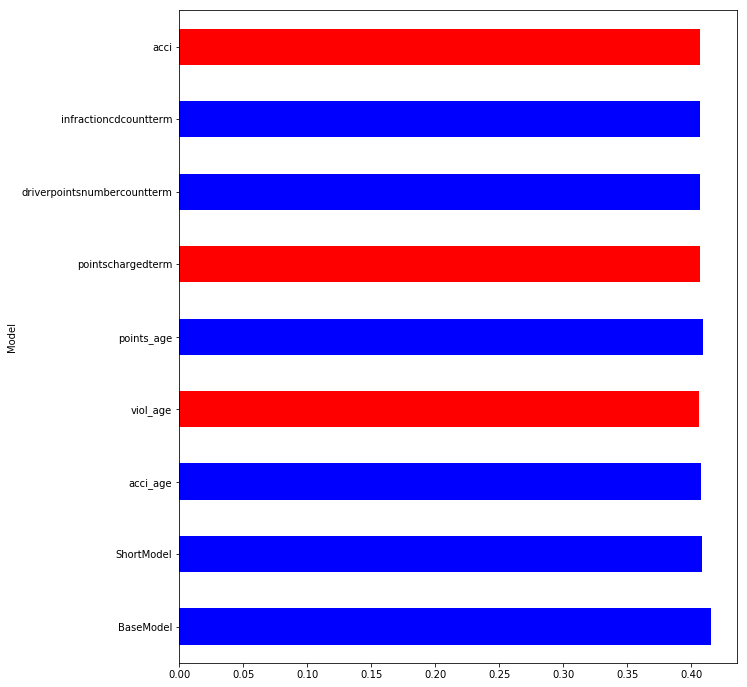

In [47]:
customcmap = tuple(models_test_gini_df['Group'].map(colors))
models_test_gini_df['Mean'].plot(kind='barh',  color=[customcmap], figsize=(10, 12))